In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from timeit import timeit


import string
import re
from stop_words import get_stop_words
import nltk, html

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, train_test_split, ParameterGrid, KFold, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
''' ******Data Creation******'''

df = pd.read_csv('development.csv')

X = df['text']
y = df['sentiment']

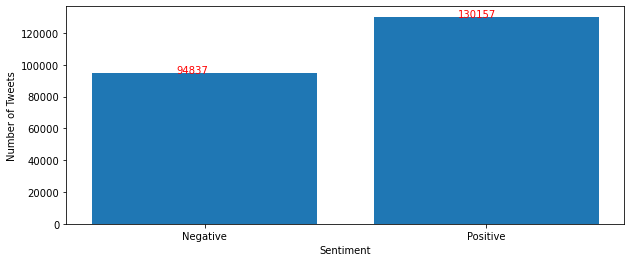

In [4]:
''' ******Data Exploration****** '''

count = Counter(y)
labels = ['Positive', 'Negative']
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(count.keys(), count.values(), tick_label = labels)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
#fig.suptitle('Number of tweets in Category')
for index, data in enumerate(sorted(count.values())):
    plt.text(x = index - .1 , y = data + 2 , s=f"{data}" , fontdict=dict(fontsize=10), color='red')
plt.show()

In [5]:
# =============Text Cleaning=============
stop_words = get_stop_words('english')
#instantiation for stemming
lemma = nltk.wordnet.WordNetLemmatizer()

def tokenize(doc):
    """Compute the tokens for each document.

    Input: a list of strings. Each item is a document to tokenize.
    Output: a list of lists. Each item is a list containing the tokens of the relative document.
    """
    tokens = []
    for tweet in doc:
        
        tweet = html.unescape(tweet) # Escaping out HTML characters
        tweet = tweet.replace('"', '') # quoting
        tweet = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", tweet) # removing email
        tweet = re.sub("(.)\\1{2,}", "\\1", tweet) # removing repeatetive letters in a word
        tweet = " ".join(tweet.split()) 
        tweet=tweet.lower() # convert to lower case
        split_doc = [lemma.lemmatize(token) for token in tweet.split(" ") if ((token not in stop_words) and (token not in string.punctuation))]
        target = ' '.join(split_doc) # getting sentence from a list
        
        tokens.append(target) # adding to final list
    return tokens

X_token = tokenize(X)

In [6]:
# =============Train-Test Split=============
X_train, X_test, y_train, y_test = train_test_split(X_token, y, test_size=.2, stratify=y, shuffle=True, random_state=42)
tfidf = TfidfVectorizer(max_features=8000, lowercase=False, sublinear_tf=True)
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)
print(tfidf.get_feature_names()[:50])

# =============Cosine Similarity=============
cosine_similarities = linear_kernel(features_train[0:1], features_train).flatten()
print(cosine_similarities)


(179995, 8000)
(44999, 8000)
['00', '00am', '01', '02', '04', '05', '06', '07', '08', '09', '10', '100', '100th', '101', '102', '10am', '10k', '10mins', '10pm', '10th', '11', '110', '11am', '11pm', '11th', '12', '120', '12th', '13', '13th', '14', '140', '140conf', '14th', '15', '150', '15mins', '15th', '16', '16th', '17', '17th', '18', '182', '1864ml', '18th', '19', '19th', '1am', '1cp2']
[1. 0. 0. ... 0. 0. 0.]


In [ ]:
''' ******Model Learning******'''
# =============Random Forest=============
clf = RandomForestClassifier(random_state = 8)

# =============Cross-Validation for Hyperparameter Tuning=============
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['sqrt']

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
             }

# =============Grid Search Cross Validation=============
# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf,
                            n_jobs=-1,
                            param_grid=param_grid,
                            scoring='f1_macro',
                            cv=cv_sets,
                            verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train[:15000], labels_train[:15000])




Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [19]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'max_features': 'sqrt', 'n_estimators': 280}

The mean accuracy of a model with these hyperparameters is:
0.744680739515534


In [20]:
print(grid_search.cv_results_)

{'mean_fit_time': array([2360.86807887, 2520.43299278, 2201.19092607, 1356.3961548 ]), 'std_fit_time': array([  3.63665939,  11.13388931, 622.37581637,  46.09104324]), 'mean_score_time': array([30.16342672, 32.88354715, 27.97769547, 24.27199864]), 'std_score_time': array([0.39407386, 0.37284739, 2.00880503, 1.24763324]), 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[280, 300, 320, 340],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 'sqrt', 'n_estimators': 280}, {'max_features': 'sqrt', 'n_estimators': 300}, {'max_features': 'sqrt', 'n_estimators': 320}, {'max_features': 'sqrt', 'n_estimators': 340}], 'split0_test_score': array([0.74577184, 0.74596466, 0.7462847 , 0.7463163 ]), 'split1_test_score': array([0.74513031, 0.74476138, 0.7446797 , 0.7

In [21]:
# =============Best Model=============
best_rfc = grid_search.best_estimator_

In [22]:
best_rfc

RandomForestClassifier(max_features='sqrt', n_estimators=280, random_state=8)

In [25]:
# =============Model Fitting and Performance=============
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

In [26]:
rfc_pred

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [28]:
# =============Training Accuracy=============
print("The training accuracy is: ")
print(f1_score(labels_train, best_rfc.predict(features_train), average='macro'))

The training accuracy is: 
0.9865870274443341


In [30]:
# =============Test Accuracy=============
print("The test accuracy is: ")
print(f1_score(labels_test, rfc_pred, average='macro'))

The test accuracy is: 
0.7470915319201987


In [31]:
# =============Classification Report=============
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     18967
           1       0.77      0.82      0.80     26032

    accuracy                           0.76     44999
   macro avg       0.75      0.74      0.75     44999
weighted avg       0.75      0.76      0.75     44999



In [53]:
# =============Confusion Matrix=============
conf_matrix = confusion_matrix(labels_test, rfc_pred)
conf_matrix

array([[12736,  6231],
       [ 4738, 21294]], dtype=int64)